# CS224N Assignment 1: Exploring Word Vectors (25 Points)
### <font color='blue'> Due 4:30pm, Tue April 9th 2024</font>

Welcome to CS224N! 

Before you start, make sure you **read the README.md** in the same directory as this notebook for important setup information. You need to install some Python libraries before you can successfully do this assignment. A lot of code is provided in this notebook, and we highly encourage you to read and understand it as part of the learning :)

If you aren't super familiar with Python, Numpy, or Matplotlib, we recommend you check out the review session on Friday. The session will be recorded and the material will be made available on our [website](http://web.stanford.edu/class/cs224n/index.html#schedule). The CS231N Python/Numpy [tutorial](https://cs231n.github.io/python-numpy-tutorial/) is also a great resource.


**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.

In [2]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------

import sys
# 确保使用 Python 3.x，且次版本号 >= 8
assert sys.version_info[0] == 3
assert sys.version_info[1] >= 8

from platform import python_version
# 进一步校验 Python 版本，不满足则报错提示升级
assert int(python_version().split(".")[1]) >= 5, "Please upgrade your Python version following the instructions in \
    the README.md file found in the same directory as this notebook. Your Python version is " + python_version()

from gensim.models import KeyedVectors  # gensim: 词向量工具库
from gensim.test.utils import datapath
import pprint                           # 用于格式化打印复杂数据结构
import matplotlib.pyplot as plt         # 绘图库
plt.rcParams['figure.figsize'] = [10, 5]  # 设置默认图表尺寸为 10×5 英寸

from datasets import load_dataset
imdb_dataset = load_dataset("stanfordnlp/imdb")  # 加载 Stanford IMDB 影评数据集

import re              # 正则表达式，用于文本预处理
import numpy as np     # 数值计算核心库
import random          # 随机数库
import scipy as sp     # 科学计算库
from sklearn.decomposition import TruncatedSVD # SVD降维
from sklearn.decomposition import PCA # PCA降维

START_TOKEN = '<START>'
END_TOKEN = '<END>'
NUM_SAMPLES = 150 # 使用150条评论

# 设置随机种子
np.random.seed(0)
random.seed(0)
# ----------------

## Word Vectors

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from *co-occurrence matrices*, and those derived via *GloVe*. 

**Note on Terminology:** The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

## Part 1: Count-Based Word Vectors (10 points)

Most word vector models start from the following idea:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](https://web.stanford.edu/~jurafsky/slp3/6.pdf) or [here](https://web.archive.org/web/20190530091127/https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

### Co-Occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window among all documents.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | `<START>` | all | that | glitters | is   | not  | gold  | well | ends | `<END>` |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| `<START>`    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| `<END>`      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

In NLP, we commonly use `<START>` and `<END>` tokens to mark the beginning and end of sentences, paragraphs, or documents. These tokens are included in co-occurrence counts, encapsulating each document, for example: "`<START>` All that glitters is not gold `<END>`".

The matrix rows (or columns) provide word vectors based on word-word co-occurrence, but they can be large. To reduce dimensionality, we employ Singular Value Decomposition (SVD), akin to PCA, selecting the top $k$ principal components. The SVD process decomposes the co-occurrence matrix $A$ into singular values in the diagonal $S$ matrix and new, shorter word vectors in $U_k$.

This dimensionality reduction maintains semantic relationships; for instance, *doctor* and *hospital* will be closer than *doctor* and *dog*.

For those unfamiliar with eigenvalues and SVD, a beginner-friendly introduction to SVD is available [here](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf). Additional resources for in-depth understanding include lectures [7](https://web.stanford.edu/class/cs168/l/l7.pdf), [8](http://theory.stanford.edu/~tim/s15/l/l8.pdf), and [9](https://web.stanford.edu/class/cs168/l/l9.pdf) of CS168, providing high-level treatment of these algorithms. For practical implementation, utilizing pre-programmed functions from Python packages like numpy, scipy, or sklearn is recommended. While applying full SVD to large corpora can be memory-intensive, scalable techniques such as Truncated SVD exist for extracting the top $k$ vector components efficiently.

### Plotting Co-Occurrence Word Embeddings

Here, we will be using the Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. We provide a `read_corpus` function below that pulls out the text of a movie review from the dataset. The function also adds `<START>` and `<END>` tokens to each of the documents, and lowercases words. You do **not** have to perform any other kind of pre-processing.

In [3]:
def read_corpus():
    """ Read files from the Large Movie Review Dataset.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    # 从训练集中取前 NUM_SAMPLES 条评论的文本
    files = imdb_dataset["train"]["text"][:NUM_SAMPLES]
    # return [[START_TOKEN] + [re.sub(r'[^\w]', '', w.lower()) for w in f.split(" ")] + [END_TOKEN] for f in files]
    
    res = []
    for f in files:
        words = []
        for w in f.split(" "):
            # 用正则去除所有非字母数字字符，并转为小写
            words.append(re.sub(r'[^\w]', '', w.lower()))
        # 在每篇评论首尾分别添加 <START> 和 <END> 标记
        res.append([START_TOKEN] + words + [END_TOKEN])
    return res


Let's have a look what these documents are like….

In [4]:
# 读取语料，并打印前 3 篇评论内容和第 1 篇评论的单词数
imdb_corpus = read_corpus()
pprint.pprint(imdb_corpus[:3], compact=True, width=100)
print("corpus size: ", len(imdb_corpus[0]))

[['<START>', 'i', 'rented', 'i', 'am', 'curiousyellow', 'from', 'my', 'video', 'store', 'because',
  'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first',
  'released', 'in', '1967', 'i', 'also', 'heard', 'that', 'at', 'first', 'it', 'was', 'seized',
  'by', 'us', 'customs', 'if', 'it', 'ever', 'tried', 'to', 'enter', 'this', 'country', 'therefore',
  'being', 'a', 'fan', 'of', 'films', 'considered', 'controversial', 'i', 'really', 'had', 'to',
  'see', 'this', 'for', 'myselfbr', 'br', 'the', 'plot', 'is', 'centered', 'around', 'a', 'young',
  'swedish', 'drama', 'student', 'named', 'lena', 'who', 'wants', 'to', 'learn', 'everything',
  'she', 'can', 'about', 'life', 'in', 'particular', 'she', 'wants', 'to', 'focus', 'her',
  'attentions', 'to', 'making', 'some', 'sort', 'of', 'documentary', 'on', 'what', 'the', 'average',
  'swede', 'thought', 'about', 'certain', 'political', 'issues', 'such', 'as', 'the', 'vietnam',
  'war', 'and', 'race', 'issu

### Question 1.1: Implement `distinct_words` [code] (2 points)

Write a method to work out the distinct words (word types) that occur in the corpus.

You can use `for` loops to process the input `corpus` (a list of list of strings), but try using Python list comprehensions (which are generally faster). In particular, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's [more information](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

Your returned `corpus_words` should be sorted. You can use python's `sorted` function for this.

You may find it useful to use [Python sets](https://www.w3schools.com/python/python_sets.asp) to remove duplicate words.

In [5]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            n_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    n_corpus_words = -1
    
    # ------------------
    # Write your implementation here.
    # 用列表推导式将二维列表展平，再用 set 去重，最后 sorted 排序
    corpus_words = sorted(list(set(word for doc in corpus for word in doc)))
    n_corpus_words = len(corpus_words)
    
    # ------------------

    return corpus_words, n_corpus_words

In [6]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# 运行此 cell 进行基本正确性检测（注意：这不是穷举测试）
# ---------------------

# Define toy corpus
# 定义一个小型测试语料：两个短句子，首尾加上 <START>、<END>
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
# 调用你实现的 distinct_words 函数，获取去重排序后的词列表和词数
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
# 标准答案：手动去重并排序后的所有单词列表
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
# 检验：去重后词的数量是否正确
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
# 检验：去重排序后的词列表是否与标准答案一致
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
# 全部通过则打印成功信息
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.2: Implement `compute_co_occurrence_matrix` [code] (3 points)

Write a method that constructs a co-occurrence matrix for a certain window-size $n$ (with a default of 4), considering words $n$ before and $n$ after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors. If you're not familiar with NumPy, there's a NumPy tutorial in the second half of this cs231n [Python NumPy tutorial](http://cs231n.github.io/python-numpy-tutorial/).


In [7]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, n_words = distinct_words(corpus)
    M = None
    word2ind = {}
    
    # ------------------
    # Write your implementation here.
    # 初始化 n_words × n_words 的全零矩阵
    M = np.zeros((n_words, n_words))
    # 构建词到矩阵行/列索引的映射字典
    word2ind = {word: i for i, word in enumerate(words)}
    
    for doc in corpus:
        for i in range(len(doc)):
            center_word = doc[i]            # 当前中心词
            center_word_idx = word2ind[center_word]

            # 遍历中心词左右 window_size 范围内的上下文词
            for j in range(max(0, i - window_size), min(len(doc), i + window_size + 1)):
                if j != i:  # 跳过中心词本身
                    context_word = doc[j]
                    context_word_idx = word2ind[context_word]
                    # 对应位置的共现计数 +1
                    M[center_word_idx, context_word_idx] += 1
    # ------------------

    return M, word2ind

In [8]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# 运行此 cell 进行基本正确性检测（注意：这不是穷举测试）
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
# 定义测试语料，用窗口大小 1 构建共现矩阵
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
# 标准答案：窗口大小为 1 时的正确共现矩阵
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
# 标准答案：排序后的词列表和对应的索引字典
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
# 检验：word2ind 映射字典是否正确
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
# 检验：共现矩阵的维度（shape）是否正确
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
# 逐元素检验：共现矩阵中每个位置的计数值是否正确
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
# 全部通过则打印成功信息
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.3: Implement `reduce_to_k_dim` [code] (1 point)

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings. 

**Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [9]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10    # Use this parameter in your call to `TruncatedSVD`
                    # 迭代次数，传给 TruncatedSVD 以提高近似精度
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # ------------------
    # Write your implementation here.
    # 使用截断 SVD 将矩阵从 (词数, 词数) 降维到 (词数, k)
    # fit_transform 返回的是 U * S，即降维后的词向量矩阵
    M_reduced = TruncatedSVD(n_components=k, n_iter=n_iters).fit_transform(M)
    
    # ------------------

    print("Done.")
    return M_reduced

In [10]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# 运行此 cell 进行基本检测（此处只检验降维后矩阵的维度是否正确）
# ---------------------

# Define toy corpus and run student code
# 用测试语料构建共现矩阵，然后调用你的降维函数
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
# 检验：降维后的矩阵应有 10 行（10 个不同的词）、2 列（k=2 维）
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
# 全部通过则打印成功信息
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.4: Implement `plot_embeddings` [code] (1 point)

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](http://web.archive.org/web/20190924160434/https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [11]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    for w in words:
        w_idx = word2ind[w]               # 获取该词在矩阵中的行索引
        # 在 2D 平面上画出该词的坐标点（红色 × 标记）
        plt.scatter(M_reduced[w_idx, 0], M_reduced[w_idx, 1], marker='x', color='red')
        # 在坐标点旁边标注单词文本
        plt.annotate(w, (M_reduced[w_idx, 0], M_reduced[w_idx, 1]))
    
    # ------------------

--------------------------------------------------------------------------------
Outputted Plot:
--------------------------------------------------------------------------------


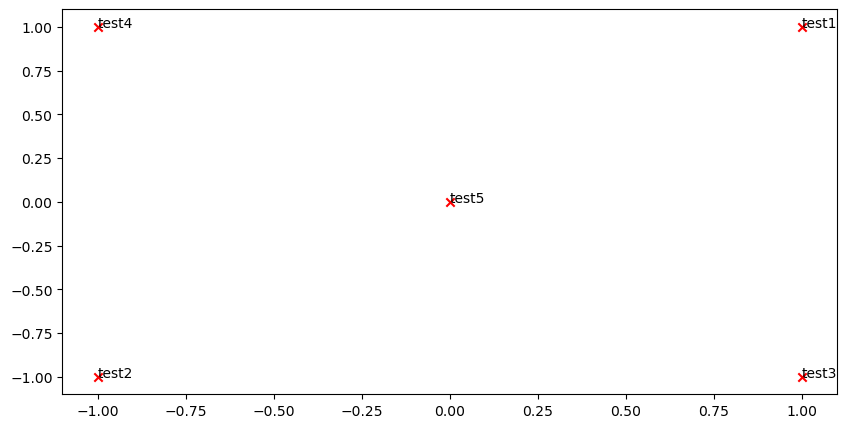

In [12]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the included file question_1.4_test.png 
# 运行此 cell 测试你的 plot_embeddings 函数
# 生成的图应与附件中的 question_1.4_test.png 一致
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

# 构造 5 个测试用的 2D 坐标点和对应的词-索引映射
M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
# 调用你实现的绘图函数，将 5 个测试词在 2D 平面上可视化
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

### Question 1.5: Co-Occurrence Plot Analysis [written] (3 points)

Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4 (the default window size), over the Large Movie Review corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U\*S, so we need to normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). **Note**: The line of code below that does the normalizing uses the NumPy concept of *broadcasting*. If you don't know about broadcasting, check out
[Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Run the below cell to produce the plot. It can take up to a few minutes to run.

Running Truncated SVD over 5880 words...
Done.


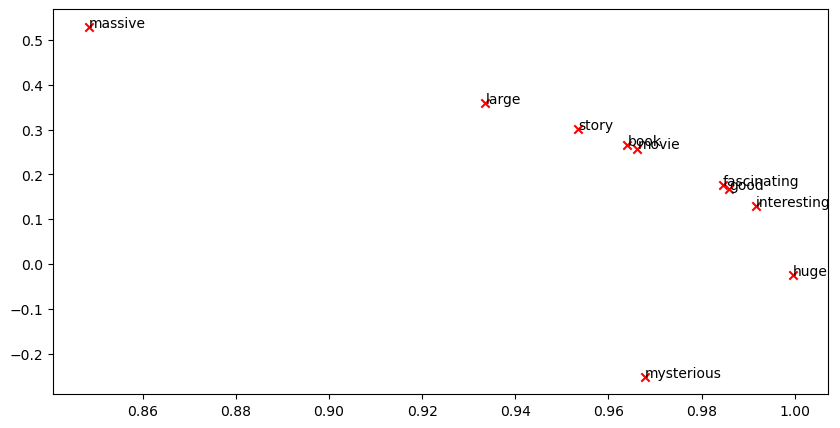

In [13]:
# -----------------------------
# Run This Cell to Produce Your Plot
# 运行此 cell 生成 Q1.5 的词向量可视化图
# ------------------------------
imdb_corpus = read_corpus()                                                         # 读取语料
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(imdb_corpus)  # 构建共现矩阵
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)                     # SVD 降维到 2 维

# Rescale (normalize) the rows to make them each of unit-length
# 将每个 2D 向量归一化为单位长度，使所有点落在单位圆上，便于比较方向
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

# 选定要可视化的 10 个词
words = ['movie', 'book', 'mysterious', 'story', 'fascinating', 'good', 'interesting', 'large', 'massive', 'huge']

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

**Verify that your figure matches "question_1.5.png" in the assignment zip. If not, use the figure in "question_1.5.png" to answer the next two questions.**

a. Find at least two groups of words that cluster together in 2-dimensional embedding space. Give an explanation for each cluster you observe.

#### <font color="red">Write your answer here.</font>
1. "book" 和 "movie"：这两个词在图中几乎重叠在一起（大约在 x=0.97~0.98, y=0.25~0.26 的位置）。原因是它们都属于叙事媒体类型，在 IMDB 电影评论语料中，人们经常同时讨论电影和原著书籍（比如改编作品的对比），因此它们共享大量相似的上下文词汇。"story" 也在它们附近，进一步印证了这一语义关联。
2. "fascinating"、"good" 和 "interesting"：这三个词紧密聚在图的右侧（大约在 x=0.99~1.00, y=0.13~0.18 的位置）。它们都是正面评价性形容词，在电影评论中经常用于表达对电影的正面感受（如 "a good/fascinating/interesting film"），共享非常相似的上下文窗口

b. What doesn't cluster together that you might think should have? Describe at least two examples.

#### <font color="red">Write your answer here.</font>
1. “large"、"massive" 和 "huge"：这三个词都是表示"大"的近义词，语义上非常接近，理应聚在一起。但从图中可以看到，"massive" 在左上角（~0.85, 0.52），"large" 在中间偏上（~0.93, 0.36），而 "huge" 却跑到了右下方（~1.00, -0.02），三者分布非常分散。这可能是因为在只有 150 条评论的小语料中，这些词的出现频率较低且上下文各不相同，导致共现统计不够稳定，SVD 降维后无法准确捕捉它们之间的近义关系。
2. "mysterious" 和 "fascinating"：这两个词在语义上有关联——都可以用来描述引人入胜的、令人好奇的事物。但在图中，"mysterious" 孤立在底部（~0.97, -0.24），远离 "fascinating"（~0.99, 0.18）。这是因为基于共现矩阵的方法依赖局部上下文窗口，"mysterious" 更多出现在描述剧情/角色的语境中，而 "fascinating" 更多出现在评价性语句中，两者的共现模式差异较大。

## Part 2: Prediction-Based Word Vectors (15 points)

As discussed in class, more recently prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). Here, we shall explore the embeddings produced by GloVe. Please revisit the class notes and lecture slides for more details on the word2vec and GloVe algorithms. If you're feeling adventurous, challenge yourself and try reading [GloVe's original paper](https://nlp.stanford.edu/pubs/glove.pdf).

Then run the following cells to load the GloVe vectors into memory. **Note**: If this is your first time to run these cells, i.e. download the embedding model, it will take a couple minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

In [14]:
# 过 gensim 库下载并加载 glove-wiki-gigaword-200 模型。
# 这是在 Wikipedia + Gigaword 语料上训练的 GloVe 向量，词汇量约 40 万个词，每个词的向量维度是 200 维。
# 返回的 wv_from_bin 是一个 gensim 的 KeyedVectors 对象，可以用它来查询词向量、计算相似度等。
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each length 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


#### Note: If you are receiving a "reset by peer" error, rerun the cell to restart the download. 

### Reducing dimensionality of Word Embeddings
Let's directly compare the GloVe embeddings to those of the co-occurrence matrix. In order to avoid running out of memory, we will work with a sample of 40000 GloVe vectors instead.
Run the following cells to:

1. Put 40000 Glove vectors into a matrix M
2. Run `reduce_to_k_dim` (your Truncated SVD function) to reduce the vectors from 200-dimensional to 2-dimensional.

### 降低词嵌入的维度
让我们直接比较 GloVe 嵌入与共现矩阵的嵌入。为了避免内存不足，我们将使用 40000 个 GloVe 向量的样本进行处理。
运行以下单元格以：

1. 将 40000 个 GloVe 向量放入矩阵 M 中
2. 运行 `reduce_to_k_dim`（你的截断奇异值分解函数），将向量从 200 维降至 2 维。

In [15]:
def get_matrix_of_vectors(wv_from_bin, required_words):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    # wv_from_bin.index_to_key 是 gensim 中存储所有词的列表（约 40 万个词），按词频从高到低排列。
    words = list(wv_from_bin.index_to_key) 
    print("Shuffling words ...")
    # 设置随机种子，确保每次打乱顺序相同
    random.seed(225)
    # 打乱词顺序
    random.shuffle(words)
    print("Putting %i words into word2ind and matrix M..." % len(words))
    # 创建词到索引的映射字典
    word2ind = {}
    # 创建一个空列表，用于存储词向量
    M = []
    # 当前索引
    curInd = 0
    # 遍历所有词
    for w in words:
        try:
            # 取出该词的 200 维向量，追加到列表 M 中。
            M.append(wv_from_bin.get_vector(w))
            # 将该词的索引 curInd 存入字典 word2ind 中。
            word2ind[w] = curInd
            # 索引 curInd 加 1。
            curInd += 1
        except KeyError:
            continue
    # 遍历 required_words 列表中的词
    # required_words 是调用者传入的一组必须出现在矩阵中的词
    for w in required_words:
        # 如果词 w 在 words 列表中，则跳过
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    # 将列表 M 转换为 numpy 数组，把它们堆叠成一个 shape 为 (约400000, 200) 的二维 numpy 矩阵。
    # 矩阵 M 的每一行对应一个词的 200 维向量。
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [ ]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin, words)
# 调用 reduce_to_k_dim 函数，将 200 维的词向量降维到 2 维。
# 降维后每个词只有 2 个分量，可以在 2D 平面上画出来。
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
# 将降维后的每个词向量归一化，使它们的长度为 1。
# 归一化后，每个词向量在 2D 平面上表示为一个单位向量，便于比较它们之间的方向。
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 400000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 400000 words...
Done.


**Note: If you are receiving out of memory issues on your local machine, try closing other applications to free more memory on your device. You may want to try restarting your machine so that you can free up extra memory. Then immediately run the jupyter notebook and see if you can load the word vectors properly. If you still have problems with loading the embeddings onto your local machine after this, please go to office hours or contact course staff.**

### Question 2.1: GloVe Plot Analysis [written] (3 points)

Run the cell below to plot the 2D GloVe embeddings for `['movie', 'book', 'mysterious', 'story', 'fascinating', 'good', 'interesting', 'large', 'massive', 'huge']`.

运行下方单元格，绘制`['movie', 'book', 'mysterious', 'story', 'fascinating', 'good', 'interesting', 'large', 'massive', 'huge']`的二维 GloVe 嵌入图。


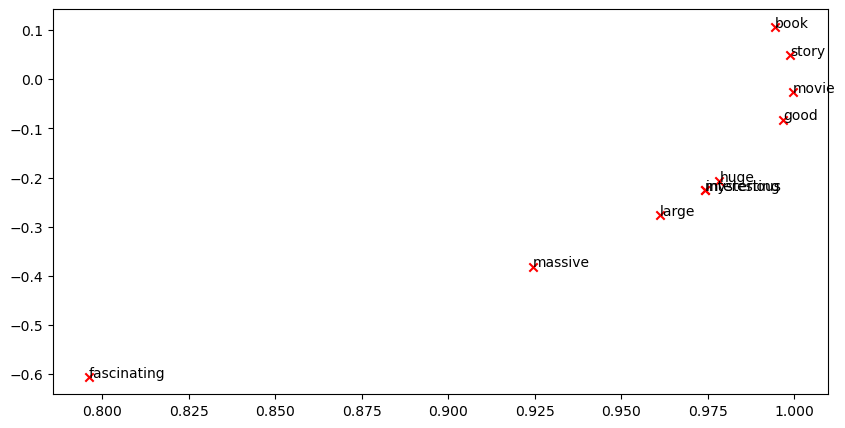

In [22]:
words = ['movie', 'book', 'mysterious', 'story', 'fascinating', 'good', 'interesting', 'large', 'massive', 'huge']

plot_embeddings(M_reduced_normalized, word2ind, words)

**Verify that your figure matches "question_2.1.png" in the assignment zip. If not, use the figure in "question_2.1.png" (and the figure in "question_1.5.png", if applicable) to answer the next two questions.**

a. What is one way the plot is different from the one generated earlier from the co-occurrence matrix? What is one way it's similar?

#### <font color="red">Write your answer here.</font>

1. 不同：
question_1.5（共现矩阵）中，"large"、"massive"、"huge" 这三个"大"的近义词——它们分散在图的不同位置（massive 在左下角远离其他词，large 在中间偏下，huge 在右上角）。而在 question_2.1（GloVe）中，"huge"、"large" 靠得比较近（都在中间区域），虽然 "massive" 稍远一些，但三者的聚集程度明显比共现矩阵图要好。
说明GloVe 更好地捕捉了同义词之间的语义关系。

2. 相似：
在两张图中，"book"、"story"、"movie" 这三个叙事媒体类的词都彼此靠近，形成一个聚类。这说明无论是共现矩阵方法还是 GloVe，都能识别出这几个词在语义上的关联。

b. Why might the GloVe plot (question_2.1.png) differ from the plot generated earlier from the co-occurrence matrix (question_1.5.png)?

#### <font color="red">Write your answer here.</font>

> 1. 训练语料不同：共现矩阵是在仅 150 条 IMDB 评论上构建的（很小的语料），而 GloVe 是在 Wikipedia + Gigaword（数十亿词的大规模语料）上训练的。语料规模差异巨大，直接影响词向量质量。
> 2. 算法不同：共现矩阵 + SVD 是一种简单的基于计数的方法；GloVe 则通过优化一个对数双线性回归目标函数来学习向量，能更好地捕捉词与词之间的语义关系（不仅仅是局部共现计数）。
> 3. 向量维度不同：共现矩阵原始维度等于词汇表大小（约 5880），SVD 降到 2 维损失很大；GloVe 原始维度只有 200，降到 2 维时信息保留得更好

### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective [L1](http://mathworld.wolfram.com/L1-Norm.html) and [L2](http://mathworld.wolfram.com/L2-Norm.html) Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

<img src="./imgs/inner_product.png" width=20% style="float: center;"></img>

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

### Question 2.2: Words with Multiple Meanings (1.5 points) [code + written] 
Polysemes and homonyms are words that have more than one meaning (see this [wiki page](https://en.wikipedia.org/wiki/Polysemy) to learn more about the difference between polysemes and homonyms ). Find a word with *at least two different meanings* such that the top-10 most similar words (according to cosine similarity) contain related words from *both* meanings. For example, "leaves" has both "go_away" and "a_structure_of_a_plant" meaning in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one. 

Please state the word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain **one** of the meanings of the words)?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 most similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance, please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [31]:
# ------------------
# Write your implementation here.
print(wv_from_bin.most_similar("mouse"))
print(wv_from_bin.most_similar("bat"))
print(wv_from_bin.most_similar("bank"))
print(wv_from_bin.most_similar("spring"))
print(wv_from_bin.most_similar("apple"))
# ------------------

[('mice', 0.6580958962440491), ('keyboard', 0.5548278093338013), ('rat', 0.5433949828147888), ('rabbit', 0.5192376971244812), ('cat', 0.5077415704727173), ('cursor', 0.5058691501617432), ('trackball', 0.5048902630805969), ('joystick', 0.49841049313545227), ('mickey', 0.47242844104766846), ('clicks', 0.4722806215286255)]
[('bats', 0.691724419593811), ('batting', 0.6160588264465332), ('balls', 0.5692734122276306), ('batted', 0.5530908107757568), ('toss', 0.5506128668785095), ('wicket', 0.5495278835296631), ('pitch', 0.5489361882209778), ('bowled', 0.5452010631561279), ('hitter', 0.5353438854217529), ('batsman', 0.5348091125488281)]
[('banks', 0.7625691294670105), ('banking', 0.6818838119506836), ('central', 0.6283639073371887), ('financial', 0.6166563034057617), ('credit', 0.6049750447273254), ('lending', 0.5980608463287354), ('monetary', 0.5963003039360046), ('bankers', 0.5913101434707642), ('loans', 0.5802939534187317), ('investment', 0.5740203261375427)]
[('summer', 0.8025314211845398

#### <font color="red">Write your answer here.</font>
> -  "mouse" 这个词有两个含义：(1) 动物（老鼠）；(2) 电脑外设（鼠标）。在 top-10 中，rat, mice, rabbit, cat 对应动物含义；keyboard, cursor, trackball, joystick, clicks 对应电脑鼠标含义。
> 
> -  bat, bank, spring, apple 的 top-10 都只体现了一个含义。这是因为 GloVe 给每个词只分配了一个向量。当一个词的某个含义在训练语料中远比其他含义常见时，这个唯一的向量就会被主导含义"拉走"。例如 "apple" 在现代大规模语料中作为公司名出现的频率远高于水果，所以向量几乎完全被科技公司含义占据。"mouse" 之所以成功，是因为它的两个含义（动物和电脑鼠标）在语料中都足够常见，使得向量落在了两个含义的"中间地带"。
> 
> GloVe学到的是：$\mathbf{u}_j^\top\mathbf{v}i \approx \log X{ij}$
> 
> $X_{ij}$ 是所有语境中的共现总和
> 
> 如果"bank（银行）"在语料中出现10000次，"bank（河岸）"只出现100次
> 
> 那么这个词的向量会被高频义项主导
> 
> - 解决方案：
>     - 收集词的所有出现位置
>     - 用上下文向量表示"这个出现的语境"
>     - 聚类得到不同义项
>     - 每个义项训练不同向量（bank#1, bank#2）
> 
> 但标准GloVe没有这个机制，所以存在多义词混淆问题。

### Question 2.3: Synonyms & Antonyms (2 points) [code + written] 

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words $(w_1,w_2,w_3)$ where $w_1$ and $w_2$ are synonyms and $w_1$ and $w_3$ are antonyms, but Cosine Distance $(w_1,w_3) <$ Cosine Distance $(w_1,w_2)$. 

As an example, $w_1$="happy" is closer to $w_3$="sad" than to $w_2$="cheerful". Please find a different example that satisfies the above. Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

In [32]:
# ------------------
# Write your implementation here.
w1 = "happy"
w2 = "cheerful"
w3 = "sad"

# 计算余弦距离（= 1 - 余弦相似度，越小越相似）
d_synonym = wv_from_bin.distance(w1, w2)   # 同义词之间的距离
d_antonym = wv_from_bin.distance(w1, w3)   # 反义词之间的距离

print(f"同义词距离 distance({w1}, {w2}) = {d_synonym}")
print(f"反义词距离 distance({w1}, {w3}) = {d_antonym}")

# 确保反义词距离小于同义词距离
assert d_antonym < d_synonym

# ------------------

同义词距离 distance(happy, cheerful) = 0.5172467231750488
反义词距离 distance(happy, sad) = 0.4040136933326721


#### <font color="red">Write your answer here.</font>
> 为什么反义词可能比同义词更近？
> 
> 1. 上下文分布相似
> 
> "hot" 和 "cold" 经常出现在相同的上下文
> 例如："The water is [hot/cold]", "not hot but cold"
> 所以它们的共现模式 $P(w|hot)$ 和 $P(w|cold)$ 很相似
> 
> 2. 同义词的语域差异
> 
> "happy" 可能更口语化
> "cheerful" 可能更正式/书面
> 它们用在不同的语境，导致共现模式差异大
> 
> 3. 连接到共现统计
> 
> $P(cold|ice)$ 大，$P(hot|ice)$ 小
> 但 "hot" 和 "cold" 在其他很多上下文中会一起被讨论
> 整体的 $\sum_k X_{hot,k}$ 和 $\sum_k X_{cold,k}$ 的分布可能很相似

### Question 2.4: Analogies with Word Vectors [written] (1.5 points)
Word vectors have been shown to *sometimes* exhibit the ability to solve analogies. 

As an example, for the analogy "man : grandfather :: woman : x" (read: man is to grandfather as woman is to x), what is x?

In the cell below, we show you how to use word vectors to find x using the `most_similar` function from the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar)__. The function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list (while omitting the input words, which are often the most similar; see [this paper](https://www.aclweb.org/anthology/N18-2039.pdf)). The answer to the analogy will have the highest cosine similarity (largest returned numerical value).

In [20]:
# Run this cell to answer the analogy -- man : grandfather :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man']))

[('grandmother', 0.7608445286750793),
 ('granddaughter', 0.7200808525085449),
 ('daughter', 0.7168302536010742),
 ('mother', 0.7151536345481873),
 ('niece', 0.7005682587623596),
 ('father', 0.6659888029098511),
 ('aunt', 0.6623409390449524),
 ('grandson', 0.6618767976760864),
 ('grandparents', 0.644661009311676),
 ('wife', 0.6445354223251343)]


Let $m$, $g$, $w$, and $x$ denote the word vectors for `man`, `grandfather`, `woman`, and the answer, respectively. Using **only** vectors $m$, $g$, $w$, and the vector arithmetic operators $+$ and $-$ in your answer, what is the expression in which we are maximizing cosine similarity with $x$?

Hint: Recall that word vectors are simply multi-dimensional vectors that represent a word. It might help to draw out a 2D example using arbitrary locations of each vector. Where would `man` and `woman` lie in the coordinate plane relative to `grandfather` and the answer?

#### <font color="red">Write your answer here.</font>

构造的目标向量 $\mathbf{t}$ 是：
$$\mathbf{t} = \mathbf{x}_b - \mathbf{x}_a + \mathbf{x}_c$$

然后在词表里找 $\arg\max_i \cos(\mathbf{t}, \mathbf{x}_i)$

cosine similarity 等价于"只比较方向，不比较长度"。词向量的长度常受词频等因素影响；类比更关心"语义方向"。所以使用余弦相似度


### Question 2.5: Finding Analogies [code + written]  (1.5 points)
a. For the previous example, it's clear that "grandmother" completes the analogy. But give an intuitive explanation as to why the `most_similar` function gives us words like "granddaughter", "daughter", or "mother?

解释grandmother之外的结果，为什么除了grandmother，还有granddaughter、daughter？

#### <font color="red">Write your answer here.</font>

> 根据公式：
> $$\text{target} = \text{grandfather} - \text{man} + \text{woman}$$
> 
> 第一步：grandfather - man = ?
> - 提取"祖辈关系"的语义
> - 但也包含"年长"、"家庭成员"等特征
> 
> 第二步：+ woman
> - 加入"女性"特征
> 结果：
> - grandmother ✅（祖辈 + 女性）
> - granddaughter（孙辈 + 女性，因为向量空间中"家庭关系"的维度接近）
> - daughter（晚辈 + 女性）
> - mother（长辈 + 女性）
> 
> 结论：
> 
> 向量空间中的"语义维度"不是完全正交的。维度太低会欠拟合（需要至少 gender + leadership 维度来表示 king/queen/man/woman）
> 
> 即使是200维，也无法完美地把所有语义关系分离，所以会有"语义泄漏"。

b. Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note**: You may have to try many analogies to find one that works!

如果要找成功的类比，首先应该窗口的大小影响捕捉的关系类型：
- 小窗口：句法关系（如辞行、时态）
- 大窗口：语义关系（如国家、首都）

GloVe通常用窗口大小约8，所以应该在语义类比上表现好。

In [36]:
# For example: x, y, a, b = ("", "", "", "")
# ------------------
# Write your implementation here.

# 性别类比（语义）
pprint.pprint(wv_from_bin.most_similar(positive=['king', 'woman'], negative=['man']))

# 国家-首都（语义）
# pprint.pprint(wv_from_bin.most_similar(positive=['france', 'paris'], negative=['italy']))

# 词性类比（句法）
pprint.pprint(wv_from_bin.most_similar(positive=['quick', 'slowly'], negative=['slow']))

x, y, a, b = ("france", "paris", "italy", "rome")

pprint.pprint(wv_from_bin.most_similar(positive=[a, y], negative=[x]))

# ------------------

# Test the solution
assert wv_from_bin.most_similar(positive=[a, y], negative=[x])[0][0] == b

[('queen', 0.6978678107261658),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998258590698),
 ('elizabeth', 0.5463595986366272),
 ('daughter', 0.5399126410484314),
 ('kingdom', 0.5318052768707275),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164473056793213)]
[('quickly', 0.6525375843048096),
 ('finally', 0.5755026936531067),
 ('then', 0.5415216684341431),
 ('soon', 0.5269242525100708),
 ('turning', 0.5224605202674866),
 ('away', 0.521220862865448),
 ('turn', 0.5149972438812256),
 ('quietly', 0.5138120651245117),
 ('immediately', 0.5122365355491638),
 ('into', 0.5081465244293213)]
[('rome', 0.7585406303405762),
 ('milan', 0.6850501298904419),
 ('italian', 0.6647830009460449),
 ('venice', 0.6126590967178345),
 ('turin', 0.5984683036804199),
 ('florence', 0.5939043760299683),
 ('bologna', 0.5863773822784424),
 ('naples', 0.5858203172683716),
 ('prohertrib', 0.5709968209266663),
 ('genoa', 0.5506733655929565)]


#### <font color="red">Write your answer here.</font>

> france : paris :: italy : rome
>
> This analogy holds because the relationship between France and Paris (country to its capital) is the same as the relationship between Italy and Rome. The word vectors successfully capture this "country-capital" relationship as a consistent vector offset, so subtracting the country vector and adding another country's vector correctly points to that country's capital.

### Question 2.6: Incorrect Analogy [code + written] (1.5 points)
a. Below, we expect to see the intended analogy "hand : glove :: foot : **sock**", but we see an unexpected result instead. Give a potential reason as to why this particular analogy turned out the way it did?

In [39]:
pprint.pprint(wv_from_bin.most_similar(positive=['foot', 'glove'], negative=['hand']))

[('45,000-square', 0.4922032654285431),
 ('15,000-square', 0.4649604558944702),
 ('10,000-square', 0.4544755816459656),
 ('6,000-square', 0.44975775480270386),
 ('3,500-square', 0.444133460521698),
 ('700-square', 0.44257497787475586),
 ('50,000-square', 0.4356396794319153),
 ('3,000-square', 0.43486514687538147),
 ('30,000-square', 0.4330596923828125),
 ('footed', 0.43236875534057617)]


#### <font color="red">Write your answer here.</font>

GloVe学到的是 $\mathbf{u}_j^\top\mathbf{v}i \approx \log X{ij}$

> 1. 在语料中，"glove" 和 "foot" 几乎不会一起出现
> 
>     foot + glove 的向量加法产生的可能是"防护装备"的语义
> 
> 2. "sock" 可能更多出现在日常用语、穿衣场景
> 
>     "glove" 可能更多出现在运动、寒冷天气场景
>     
>     它们的 $X_{sock,k}$ 和 $X_{glove,k}$ 分布差异大
> 
> 3. 期望的答案是 "sock"，但结果全是类似 "45,000-square"、"15,000-square" 这样的词。
> 
>     这是因为 foot + glove - hand 计算出来的向量，恰好被拉向了 "square foot"（平方英尺） 这个方向：
> 
>     foot 在语料中大量出现在 度量单位 的语境里（如 "a 45,000-square-foot building"） 
> 
>     这些 "XX,000-square" 其实是 "XX,000-square-foot" 在分词后的产物
> 
>     这个度量单位含义压过了"脚"的含义所以向量运算的结果指向了"平方英尺"相关的词，而不是"袜子"。

b. Find another example of analogy that does *not* hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the **incorrect** value of b according to the word vectors (in the previous example, this would be **'45,000-square'**).

In [42]:
# For example: x, y, a, b = ("", "", "", "")
# ------------------
# Write your implementation here.
# x, y, a, b = ("curry", "indian", "pizza", "italian")
x, y, a, b = ("pen", "write", "knife", "cut")

# ------------------
pprint.pprint(wv_from_bin.most_similar(positive=[a, y], negative=[x]))
assert wv_from_bin.most_similar(positive=[a, y], negative=[x])[0][0] != b

[('you', 0.48027661442756653),
 ('how', 0.45332497358322144),
 ("'d", 0.4527038335800171),
 ('cover', 0.4514838755130768),
 ('tell', 0.44960734248161316),
 ('whatever', 0.44567203521728516),
 ('piece', 0.44481360912323),
 ("'ll", 0.43800321221351624),
 ('done', 0.430388480424881),
 ('writing', 0.428756982088089)]


#### <font color="red">Write your answer here.</font>

> 设计的类比是：curry : indian :: pizza : italian
> 
> 期望输出italian，但输出的是india
> 
> pen:write :: knife:? （期望 cut）, 输出： you

### Question 2.7: Guided Analysis of Bias in Word Vectors [written] (1 point)

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Run the cell below, to examine (a) which terms are most similar to "man" and "profession" and most dissimilar to "woman" and (b) which terms are most similar to "woman" and "profession" and most dissimilar to "man". Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [43]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.

pprint.pprint(wv_from_bin.most_similar(positive=['man', 'profession'], negative=['woman']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'profession'], negative=['man']))

[('reputation', 0.5250176787376404),
 ('professions', 0.5178037881851196),
 ('skill', 0.49046966433525085),
 ('skills', 0.49005505442619324),
 ('ethic', 0.4897659420967102),
 ('business', 0.487585186958313),
 ('respected', 0.485920250415802),
 ('practice', 0.482104629278183),
 ('regarded', 0.4778572916984558),
 ('life', 0.4760662019252777)]

[('professions', 0.5957457423210144),
 ('practitioner', 0.49884122610092163),
 ('teaching', 0.48292139172554016),
 ('nursing', 0.48211804032325745),
 ('vocation', 0.4788965880870819),
 ('teacher', 0.47160351276397705),
 ('practicing', 0.46937814354896545),
 ('educator', 0.46524327993392944),
 ('physicians', 0.4628995358943939),
 ('professionals', 0.4601394236087799)]


#### <font color="red">Write your answer here.</font>

> 女性关联的职业倾向于具体的服务/教育类职业（teaching, nursing, educator），而男性关联的词更偏向抽象的能力、声望和商业（business, reputation, respected, skill），暗示男性与权威/成就挂钩。
> 
> 这反映了训练语料（Wikipedia、新闻）中的性别偏见——女性更常在"教师""护士"等语境中被提及，男性更常在"商业""受尊敬""技能"等语境中被提及。GloVe 把这种社会层面的刻板印象编码进了词向量中。

### Question 2.8: Independent Analysis of Bias in Word Vectors [code + written]  (1 point)

Use the `most_similar` function to find another pair of analogies that demonstrates some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [ ]:
# ------------------
# Write your implementation here.
# 方向1：与 european + criminal 相似，与 african 不相似
pprint.pprint(wv_from_bin.most_similar(positive=['european', 'criminal'], negative=['african']))
print()
# 方向2：与 african + criminal 相似，与 european 不相似
pprint.pprint(wv_from_bin.most_similar(positive=['african', 'criminal'], negative=['european']))

# ------------------

[('investigations', 0.5599403381347656),
 ('crimes', 0.5473870038986206),
 ('investigation', 0.5373427867889404),
 ('criminals', 0.5174946188926697),
 ('antitrust', 0.5164338946342468),
 ('crime', 0.5132272839546204),
 ('prosecutors', 0.5110832452774048),
 ('prosecution', 0.507327675819397),
 ('enforcement', 0.5033372044563293),
 ('charges', 0.4930346608161926)]

[('crimes', 0.5542032718658447),
 ('crime', 0.5206238627433777),
 ('convicted', 0.5133807063102722),
 ('murder', 0.5020079612731934),
 ('prosecution', 0.5004827976226807),
 ('charges', 0.4813272953033447),
 ('defendant', 0.48000574111938477),
 ('defendants', 0.47705507278442383),
 ('trial', 0.4734346270561218),
 ('charged', 0.4717729985713959)]


#### <font color="red">Write your answer here.</font>

> 当 "european" 与 "criminal" 关联时，top-10 中出现的词更多是调查和执法相关的词（如 investigations, prosecutors, enforcement），以及白领犯罪（antitrust）；而当 "african" 与 "criminal" 关联时，出现了更多暴力犯罪（murder）和被审判/被定罪相关的词（convicted, defendant, charged, trial）。
>
> 这反映了词向量中的种族偏见：european 更多被关联到法律体系的执法者一侧，而 african 更多被关联到被告/罪犯一侧，且涉及更严重的犯罪类型。这种偏见源自训练语料（新闻报道等）中对不同种族在犯罪话题上的不平等叙述。

### Question 2.9: Thinking About Bias [written] (2 points)

a. Give one explanation of how bias gets into the word vectors. Briefly describe a real-world example that demonstrates this source of bias. Your real-world example should be focused on word vectors, as opposed to bias in other AI systems (e.g., ChatGPT).

#### <font color="red">Write your answer here.</font>

>偏见通过训练语料进入词向量。词向量是从大规模文本的共现统计中学习的——GloVe 的优化目标
>使得向量点积近似等于 log(共现次数)。如果语料本身包含社会偏见，这种偏见就会被编码进向量中。
>
>真实例子：在新闻语料中，"doctor"与"he"的共现次数远高于与"she"的共现次数
>（因为新闻中描写男性医生的报道更多）。假设 $X_{doctor,he}$ = 1000，$X_{doctor,she}$ = 100，
>那么训练后 $v_{doctor}^T u_{he}$ ≈ log(1000) ≈ 6.9，而 $v_{doctor}^T u_{she}$ ≈ log(100) ≈ 4.6。
>这导致"doctor"在向量空间中离"male"更近。如果将这样的词向量用于简历筛选系统，
>可能会不公平地倾向于将男性候选人与医生岗位匹配。

b. What is one method you can use to mitigate bias exhibited by word vectors? Briefly describe a real-world example that demonstrates this method.


#### <font color="red">Write your answer here.</font>
>一种方法是后处理去偏（Post-processing Debiasing，Bolukbasi et al. 2016）。
>具体做法是：
>1. 用已知的性别词对（如 he-she、man-woman）识别出向量空间中的"性别方向"
>2. 对于不应有性别倾向的词（如 doctor、nurse、engineer），
>   将它们在"性别方向"上的分量投影去除，使其变为零
>
>真实例子：Bolukbasi et al. 在 2016 年的研究中对 Google News 训练的 word2vec 向量
>应用了这种方法。处理前，"computer programmer"与"man"的关联度远高于"woman"；
>处理后，这类职业词在性别方向上变为中性，不再偏向任何一方。

# <font color="blue"> Submission Instructions</font>

1. Click the Save button at the top of the Jupyter Notebook.
2. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of all cells). 
2. Select Cell -> Run All. This will run all the cells in order, and will take several minutes.
3. Once you've rerun everything, select File -> Download as -> PDF via LaTeX (If you have trouble using "PDF via LaTex", you can also save the webpage as pdf. <font color='blue'> Make sure all your solutions especially the coding parts are displayed in the pdf</font>, it's okay if the provided codes get cut off because lines are not wrapped in code cells).
4. Look at the PDF file and make sure all your solutions are there, displayed correctly. The PDF is the only thing your graders will see!
5. Submit your PDF on Gradescope.